In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
from datetime import datetime as dt
import pandas_market_calendars as mcal
import dateutil

In [2]:
# get range of dates from the last 100 days
import datetime
numdays = 100
# get current date
base = datetime.datetime.today()
# list comp for current date - number of days for range of dates
date_list = [base - datetime.timedelta(days=x) for x in range(numdays)]
# put into dataframe to do datetime formatting
dates = pd.DataFrame(date_list, columns = ['dates'])
dates['dates'] = pd.to_datetime(dates.dates)
dates['dates'] = dates['dates'].dt.strftime('%Y-%m-%d')
# sort dates ascending values
dates = dates.sort_values(by="dates", ascending=True)
# all dates are in a list to use in REST API to fetch data
dates = list(dates['dates'])

In [2]:
ticker = 'X:ETCUSD'
range_agg = '/range/1/day/'
unadjusted = 'unadjusted=true'
sort = '&sort=asc'
limit = '&limit=50000'
POLYGON_URL = 'https://api.polygon.io/v2/aggs/ticker/'
from_date = '2013-12-06'
to_date = '2021-06-29'
POLYGON_API = '&apiKey=x6XqEaDjOWJXwVQRyBQ5kMEi8KlCYZqo'

In [3]:
datetime = []
open_price = []
high_price = []
low_price = []
close_price = []
volume = []
#for date in dates:
polygon = POLYGON_URL + ticker + range_agg + from_date + '/' + to_date + '?' + unadjusted + sort + limit + POLYGON_API
r_polygon = requests.get(polygon)
polygon_response = r_polygon.json()
for aggs in range(len(polygon_response['results'])):
    datetime.append(dt.fromtimestamp(polygon_response['results'][aggs]['t']/ 1000.0).strftime('%Y-%m-%d %H:%M:%S'))
    open_price.append(polygon_response['results'][aggs]['o'])
    high_price.append(polygon_response['results'][aggs]['h'])
    low_price.append(polygon_response['results'][aggs]['l'])
    close_price.append(polygon_response['results'][aggs]['c'])
    volume.append(polygon_response['results'][aggs]['v'])

In [4]:
df = pd.DataFrame(list(zip(datetime,open_price,high_price,low_price, close_price,volume)),
columns =['datetime', 'open', 'high', 'low', 'close', 'volume'])

In [5]:
df.head()

,datetime,open,high,low,close,volume
0,2017-01-01 00:00:00,1.4100,1.50171,1.33000,1.3965,185397.441200
1,2017-01-02 00:00:00,1.3775,1.46000,1.35385,1.4316,147730.370264
2,2017-01-03 00:00:00,1.4324,1.57230,1.39860,1.4768,274646.676141
3,2017-01-04 00:00:00,1.4758,1.76271,1.43333,1.7200,504785.741390
4,2017-01-05 00:00:00,1.7200,1.84999,1.39569,1.5956,589274.723605


In [6]:
len(df)

1641

In [7]:
df['datetime']

0       2017-01-01 00:00:00
1       2017-01-02 00:00:00
2       2017-01-03 00:00:00
3       2017-01-04 00:00:00
4       2017-01-05 00:00:00
               ...         
1636    2021-06-25 00:00:00
1637    2021-06-26 00:00:00
1638    2021-06-27 00:00:00
1639    2021-06-28 00:00:00
1640    2021-06-29 00:00:00
Name: datetime, Length: 1641, dtype: object

In [8]:
df.describe()

,open,high,low,close,volume
count,1641.000000,1641.000000,1641.000000,1641.000000,1.641000e+03
mean,12.435563,13.721991,10.979966,12.370791,1.646559e+06
std,13.989966,17.753014,10.359572,13.606732,1.611384e+06
min,1.171100,1.205300,0.100000,1.173000,1.612564e+04
25%,5.236000,5.662700,4.980000,5.250780,5.920040e+05
50%,7.395390,7.900000,6.944780,7.446300,1.220318e+06
75%,15.137310,15.971760,13.980000,15.128840,2.174446e+06
max,141.059000,300.000000,78.301030,141.059000,1.608063e+07


In [9]:
# Select only the important features i.e. the date and price
data = df[["datetime","close"]] # select Date and Price
# Rename the features: These names are NEEDED for the model fitting
data = data.rename(columns = {"datetime":"ds","close":"y"}) #renaming the columns of the dataset
data.tail(5)

,ds,y
1636,2021-06-25 00:00:00,39.392
1637,2021-06-26 00:00:00,40.666
1638,2021-06-27 00:00:00,42.323
1639,2021-06-28 00:00:00,43.358
1640,2021-06-29 00:00:00,56.380


In [10]:
from prophet import Prophet
m = Prophet(daily_seasonality = True) # the Prophet class (model)
m.fit(data) # fit the model using all data

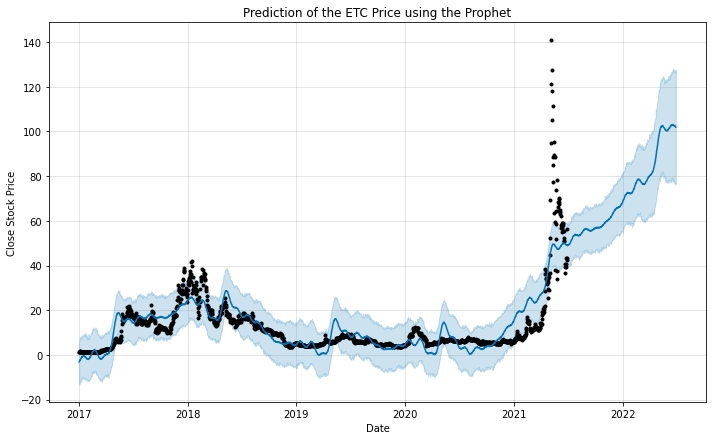

In [12]:
future = m.make_future_dataframe(periods=365) #we need to specify the number of days in future
prediction = m.predict(future)
m.plot(prediction)
plt.title("Prediction of the ETC Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

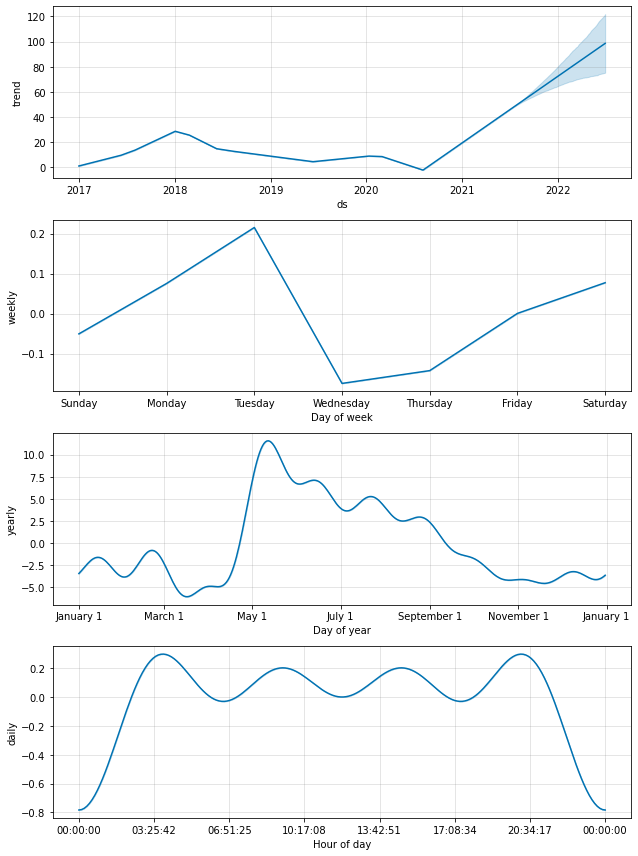

In [13]:
m.plot_components(prediction)
plt.show()

In [14]:
# try with some hyperparameter tuning
# Python
import itertools
import numpy as np
import pandas as pd
from prophet.diagnostics import cross_validation, performance_metrics

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(data)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 83 forecasts with cutoffs between 2018-01-16 00:00:00 and 2021-05-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fe9b63f0190>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 83 forecasts with cutoffs between 2018-01-16 00:00:00 and 2021-05-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fe9c2327850>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 83 forecasts with cutoffs between 2018-01-16 00:00:00 and 2021-05-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fe9b63b2cd0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_se

    changepoint_prior_scale  seasonality_prior_scale       rmse
0                     0.001                     0.01  16.749672
1                     0.001                     0.10  17.604915
2                     0.001                     1.00  17.632839
3                     0.001                    10.00  17.615230
4                     0.010                     0.01  13.023696
5                     0.010                     0.10  13.312000
6                     0.010                     1.00  13.317347
7                     0.010                    10.00  13.262450
8                     0.100                     0.01  11.260118
9                     0.100                     0.10  11.338758
10                    0.100                     1.00  11.301833
11                    0.100                    10.00  11.211680
12                    0.500                     0.01  10.570769
13                    0.500                     0.10  11.511500
14                    0.500             

In [15]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}


In [23]:
m = Prophet(daily_seasonality = True, changepoint_prior_scale=0.5, seasonality_prior_scale=0.01) # the Prophet class (model)
m.fit(data)

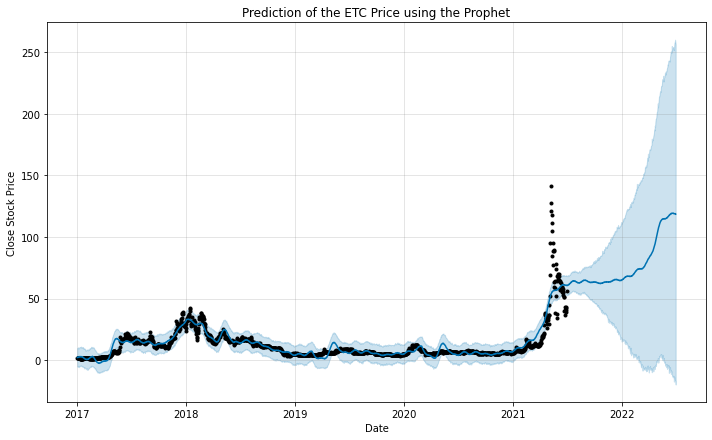

In [24]:
future = m.make_future_dataframe(periods=365) #we need to specify the number of days in future
prediction = m.predict(future)
m.plot(prediction)
plt.title("Prediction of the ETC Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

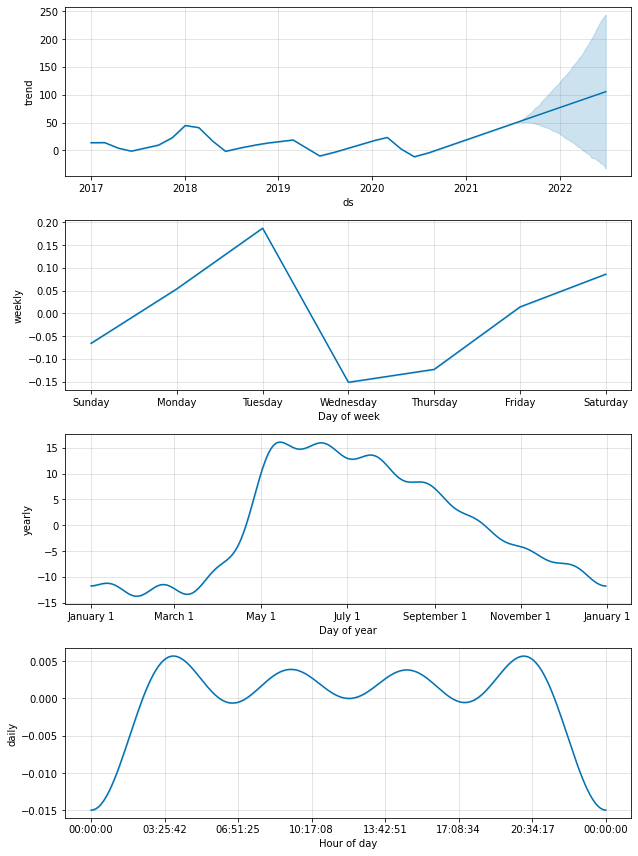

In [25]:
m.plot_components(prediction)
plt.show()